In [1]:
#initialize dependencies, h2o as primary
import datetime  # for timestamp
import h2o  # base h2o package for python
from h2o.estimators.glm import H2OGeneralizedLinearEstimator  # h2o elastic net models class
from h2o.grid.grid_search import H2OGridSearch  # grid search class and syntax for h2o models
from interpret import show  # basic visualizations from interpret package
from interpret.glassbox import ExplainableBoostingClassifier  # interpret ebm class
from interpret.perf import ROC  # ROC measure for ebm
import itertools  # for cartesian product of parameters
import matplotlib.pyplot as plt  # basic plotting
import numpy as np  # for basic array manipulation
import pandas as pd  # for dataframe manipulation
import seaborn as sns  # slightly better plotting
import time  # for timers
import xgboost as xgb  # base xgboost package for python

# set numpy random seed for better reproducibility
SEED = 12345

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='6G',
         nthreads=NTHREAD)  # start h2o with plenty of memory and threads
h2o.remove_all()  # clears h2o memory
h2o.no_progress()  # turn off h2o progress indicators

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Zulu11.37+18-SA (build 11.0.6+10-LTS, mixed mode)
  Starting server from C:\Users\zvila\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\zvila\AppData\Local\Temp\tmp32jd_9dn
  JVM stdout: C:\Users\zvila\AppData\Local\Temp\tmp32jd_9dn\h2o_zvila_started_from_python.out
  JVM stderr: C:\Users\zvila\AppData\Local\Temp\tmp32jd_9dn\h2o_zvila_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,37 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,10 days
H2O_cluster_name:,H2O_from_python_zvila_ba9jw7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [3]:
#import data (test data will not be used for model fitting)
data = pd.read_csv('hmda_train_preprocessed.csv')
test = pd.read_csv('hmda_test_preprocessed.csv')

# Feature Assignment (Parametric Model)

In [4]:
#assign x and y features
y_name = 'high_priced'
x_names = [
    'term_360', 'conforming', 'debt_to_income_ratio_missing',
    'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
    'intro_rate_period_std', 'property_value_std', 'income_std',
    'debt_to_income_ratio_std'
]

## Boxplots of Features

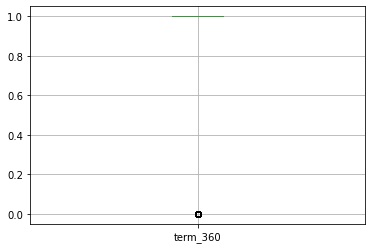

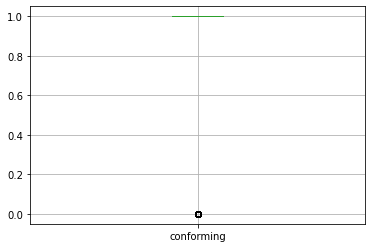

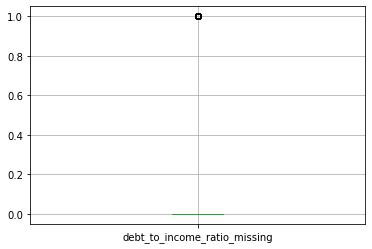

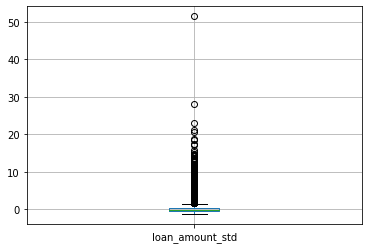

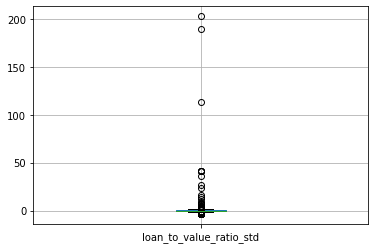

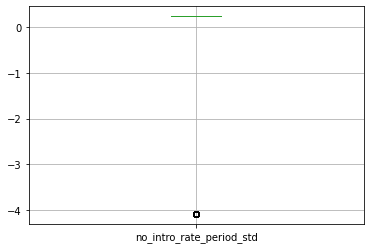

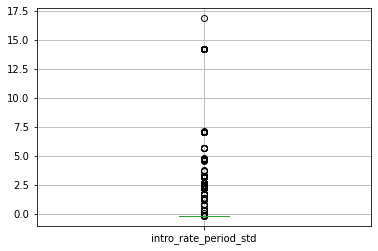

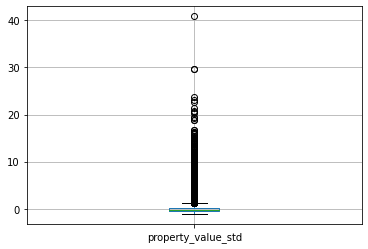

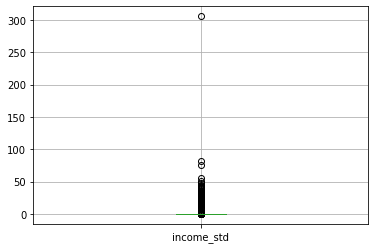

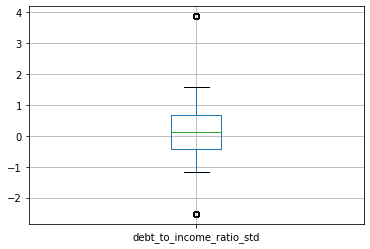

In [18]:
#data exploration with boxplots
for i in data[x_names]:
    data[x_names].boxplot(column=i)
    plt.show()

# Correlation of Features & Predictor (High-Priced)

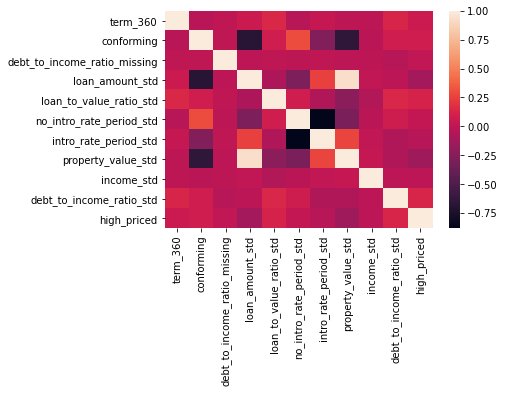

In [6]:
#correlation analysis
corr = data[x_names + [y_name]].corr()
_ = sns.heatmap(corr,
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

# Data Partitioning: Training & Validation Sets

In [7]:
#partition data
np.random.seed(SEED)  # preserve reproducibility

split_ratio = 0.75  # 75%/25% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Training data = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data = %d, columns = %d' %
      (valid.shape[0], valid.shape[1]))

Train data rows = 120254, columns = 23
Validation data rows = 40084, columns = 23


# Explainable Boosting Machine Model

In [8]:
#Define function for random grid search
def ebm_grid(train,
             valid,
             x_names,
             y_name,
             gs_params=None,
             n_models=None,
             early_stopping_rounds=None,
             seed=None):
    """ Performs a random grid search over n_models and gs_params.

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.   
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED)

    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {
        'n_jobs': NTHREAD,
        'early_stopping_rounds': early_stopping_rounds,
        'random_state': SEED
    }

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp]
                      )  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train
        ebm = ExplainableBoostingClassifier(**params)
        candidate = ebm.fit(train[x_names], train[y_name])

        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[x_names],
                                                       valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']

        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_candidate = candidate
            best_score = candidate_best_score
            print(
                'Grid search new best score discovered at iteration %d/%d: %.4f.'
                % (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')

        del ebm

    return best_candidate

# Random Grid Search: EBM fit (10 iterations)

### Utilize Early Stopping to minimize overfitting

In [9]:
# dictionary of hyperparameter value lists for grid search
gs_params = {
    'max_bins': [128, 256, 512],
    'max_interaction_bins': [16, 32, 64],
    'interactions': [5, 10, 15],
    'outer_bags': [4, 8, 12],
    'inner_bags': [0, 4],
    'learning_rate': [0.001, 0.01, 0.05],
    'validation_size': [0.1, 0.25, 0.5],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaves': [1, 3, 5]
}

# EBM grid search, use early stopping
best_ebm = ebm_grid(train,
                    valid,
                    x_names,
                    y_name,
                    gs_params=gs_params,
                    n_models=10,
                    early_stopping_rounds=100,
                    seed=SEED)

Grid search run 1/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
Grid search new best score discovered at iteration 1/10: 0.8212.
---------- ----------
Grid search run 2/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 3/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max

# Model Assessment: AUC of Best Model

In [10]:
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(
    valid[x_names], valid[y_name])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.8246.


In [11]:
#create submission file
best_ebm_submit = pd.DataFrame(best_ebm.predict_proba(test[x_names])[:, 1],
                               columns=['phat'])
best_ebm_submit.to_csv(
    'ph_best_ebm_' +
    str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'),
    index=False)

In [13]:
#end h2o
h2o.cluster().shutdown(prompt=False)

H2O session _sid_9850 closed.
